In [1]:
from main import load_model, load_data, fit_regressor

from src.autoencoder import Encoder, Decoder
from src.data_setup import SLADataset
from src.regressor import MetaRegression, Regression
from src.criterion import Masked_Loss, GDL, Loss

import torch
from torch import nn
from torch.utils.data import DataLoader

import xarray as xr
import numpy as np
from datetime import date, datetime
from pathlib import Path
import matplotlib.pyplot as plt
import logging

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASEPATH = Path("/work3/s176531/data_v6")
SAVEFOLDER = Path("saved")
SAVEFOLDER.mkdir(parents=True, exist_ok=True)
# load_path = Path("saved/checkpoint_1000.pkl")
load_path = Path(BASEPATH.parent, "autoencoder_ckpt", "checkpoint_1000.pkl")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
encoder, decoder, optimizer, training_loss, validation_loss, fill_nan, epoch, train_start, train_end, validation_end = load_model(load_path, DEVICE)

In [3]:
data_path = BASEPATH / "without_polar_v6_mss21.nc"
save_path = SAVEFOLDER / "Regression.pkl"
batch_size = 10

train_loader, validation_loader, test_loader, lat, lon = load_data(
    train_start, 
    train_end, 
    validation_end,
    data_path,
    save_path,
    batch_size,
    fill_nan,
    is_trained = True
)

In [4]:
with torch.no_grad():
    encoder.eval()
    decoder.eval()
    
    features, mask, _ = next(iter(validation_loader))
    features = features.to(DEVICE)
    mask = mask.to(DEVICE)
    
    # encode-decode training data
    feature_space = encoder(features)
    output = decoder(feature_space)

In [5]:
# features[mask.unsqueeze(1)] = np.nan
# output[mask.unsqueeze(1)] = np.nan

In [6]:
mse_loss = Masked_Loss(nn.MSELoss)
gdl_loss = GDL()
criterion = Loss([mse_loss, gdl_loss])

/zhome/14/5/130553/Desktop/Speciale/Experiments/AltimeterAutoencoder/src/criterion.py:65: UserWarning: Mask was not set in GDL
  warnings.warn("Mask was not set in GDL")


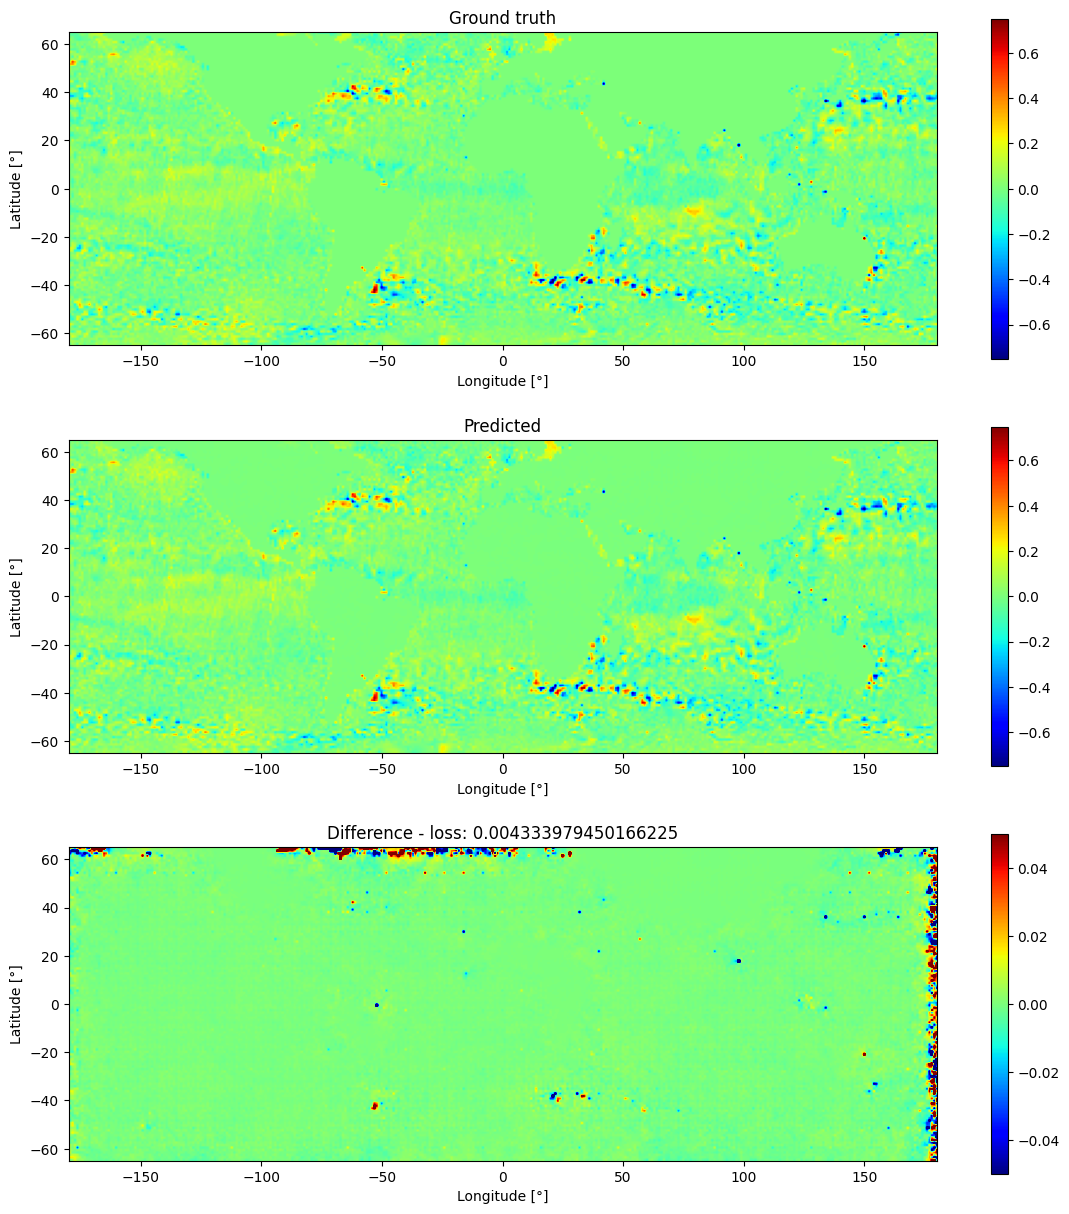

In [7]:
ground_truth = features[0,0,0].cpu()
predicted = output[0,0,0].detach().cpu().numpy()
loss = criterion(features.squeeze(2), output.squeeze(2))

fig, ax = plt.subplots(3,1,figsize=(14,15))
im1=ax[0].imshow(ground_truth, extent=[-180,180,-65,65], origin="lower", vmin=-.75, vmax=.75, cmap="jet")
ax[0].set_xlabel(f"Longitude [\N{DEGREE SIGN}]")
ax[0].set_ylabel(f"Latitude [\N{DEGREE SIGN}]")
ax[0].set_title("Ground truth")

im2=ax[1].imshow(predicted, extent=[-180,180,-65,65], origin="lower", vmin=-.75, vmax=.75, cmap="jet")
ax[1].set_xlabel(f"Longitude [\N{DEGREE SIGN}]")
ax[1].set_ylabel(f"Latitude [\N{DEGREE SIGN}]")
ax[1].set_title("Predicted")

im3=ax[2].imshow(ground_truth-predicted, extent=[-180,180,-65,65], origin="lower", vmin=-.05, vmax=.05, cmap="jet")
ax[2].set_xlabel(f"Longitude [\N{DEGREE SIGN}]")
ax[2].set_ylabel(f"Latitude [\N{DEGREE SIGN}]")
ax[2].set_title(f"Difference - loss: {loss}")

fig.colorbar(im1)
fig.colorbar(im2)
fig.colorbar(im3)
plt.show()

In [8]:
feature_space.shape

torch.Size([10, 1, 128, 16, 45])

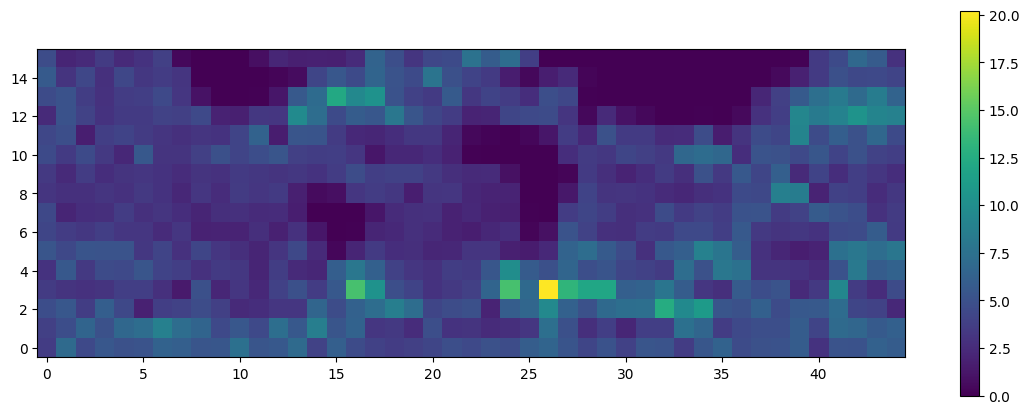

In [28]:
i = 0
plt.figure(figsize=(14,5))
plt.imshow(feature_space[0,0,i].cpu().numpy(), origin='lower')
plt.colorbar()
plt.show()